In [1]:
import numpy as np
import argparse

In [2]:
from pathlib import Path
from tqdm import tqdm
import time

In [3]:
base_path = Path(r'C:\Users\Jesse\Google Drive\Learning\Medicine\MdPhD\Y1S1\Bio Algs\BioAlgs_projects\ex_1')

# segmentation

In [4]:
def read_signal_file(filepath: str) -> np.ndarray:
    """
    Read signal data from a tab-separated text file.
    Each line contains one or more columns of values separated by tabs.

    Args:
        filepath: Path to the input text file

    Returns:
        np.ndarray: Array of signal values from all columns
    """
    return np.loadtxt(filepath, delimiter='\t', dtype=np.float32)

In [5]:
def print_segments(s: np.ndarray, c: float) -> None:
    """
    Print segments array with 3 decimal places.
    Each row contains [start, end, average].

    Args:
        s: numpy array of shape (n_segments, 3)
        c: Total cost value of optimal segmentation
    """
    for row in s:
        print(f"{int(row[0])} {int(row[1])} {np.round(row[2], 3)}")
    print(np.round(c, 3))
    return

In [8]:
def mean(segment: list[str]) -> float:
    """Calculates the mean of a segment.

    Args:
        segment (list[str]): An input list representing a segment.

    Returns:
        float: The mean of the segment.
    """
    return sum(float(x) for x in segment) / len(segment)

def cost_segment(segment: list[str], mean_seg: float) -> float:
    """Calculates the cost of a segment.

    Args:
        segment (list[str]): An input list representing a segment.
        mean_seg (float): The mean of the segment.

    Returns:
        float: The cost of the segment.
    """
    return sum((float(x) - mean_seg) ** 2 for x in segment)


In [6]:
def segment(x: np.ndarray, p: float, q: int):
    """
    Segment a signal using dynamic programming.
    
    Args:
        x: Input signal (numpy 1d array)
        p: Penalty parameter
        q: Maximum segment length
    
    Returns:
        s: numpy Array of segments. Shaped (n, 3), each row in format [start, end, average]
        c: Total cost value of optimal segmentation
    """
    n = len(x)

    # min cost for segmenting the prefix x[0...i-1]
    costs = np.full(n + 1, np.inf)
    # since the penalty is for every added segment, we deduct the penalty of the first segment [X_0:X_n]
    costs[0] = -p
    
    # start index of the last segment for the optimal
    # solution covering x[0...i-1]
    traceback = np.zeros(n + 1, dtype=int)


    s = np.zeros(n + 1)
    s2 = np.zeros(n + 1)
    np.cumsum(x, out=s[1:])
    np.cumsum(x**2, out=s2[1:])
    def quick_seg_cost(j, i):
        length = i - j
        # sum of values in x[j:i]
        sum_val = s[i] - s[j]
        # sum of squared values in x[j:i]
        sum_sq_val = s2[i] - s2[j]
        # Cost = sum(x^2) - (sum(x))^2 / N
        return sum_sq_val - (sum_val**2) / length
    
    # iterate over each possible prefix length to calc costs[i], i from 1 to n
    for i in range(1, n + 1):
        # j is the start index of the last segment 0-based
        # for prefix length of i, the last element is x[i-1]
        # The segment is x[j...i-1], its length is i-j. We need i-j <= q, so j >= i-q
        for j in range(max(0, i - q), i):
            # The cost of the optimal solution before this segment started
            # is the one that covers the prefix x[0...j-1], which is costs[j].
            cost_seg = quick_seg_cost(j, i)

    
            # this way we get total loss per previous segments
            # (including (num segments) * (p - 1))
            # + cur segment + p = total cost
            # costs[j] = cost for the prefix x[0...j-1]
            # cost_seg = cost for the current segment x[j...i-1]
            cur_total_cost = costs[j] + cost_seg + p
    
    
            # if we found a better cost for prefix x[0...i-1], update
            if cur_total_cost < costs[i]:
                # update min cost for prefix x[0...i-1]
                costs[i] = cur_total_cost
                # update start index of the last segment.
                # notice traceback[i] can be overwritten multiple times
                traceback[i] = j
    
    segments = []
    end_idx =n
    
    while end_idx > 0:
        start_idx = traceback[end_idx]
        seg = x[start_idx:end_idx]
    
        mean_seg = mean(seg)
        # we save segments as one based, not zero based. 
        segments.insert(0, [start_idx + 1, end_idx, mean_seg])
        end_idx = start_idx
    
    total_cost = costs[n]
    return segments, total_cost



In [39]:
seg_scores = np.array([segement[2] for segement in segments])
seg_scores.sum(),seg_scores.shape

(14.273198710904149, (23,))

In [67]:
x=read_signal_file(str(base_path / 'input.txt'))

In [70]:
segment(x,p=0.1,q=50)

([[1, 28, 0.9626156091690063],
  [29, 29, 0.50627601146698],
  [30, 39, 0.13641926124691964],
  [40, 88, 0.9511549022732949],
  [89, 98, 0.055451540276408195],
  [99, 104, 0.2605120042959849],
  [105, 151, 0.9338114007990411],
  [152, 153, 0.2613984942436218],
  [154, 172, 0.9192254260966652],
  [173, 214, 0.9632223830336616],
  [215, 216, 0.666485995054245],
  [217, 224, 0.38451162353157997],
  [225, 237, 0.08241241668852475],
  [238, 239, 0.7379134893417358],
  [240, 242, 0.18870640297730765],
  [243, 250, 0.9727911278605461],
  [251, 266, 0.6788649447262287],
  [267, 271, 0.9419333934783936],
  [272, 282, 0.6847699121995405],
  [283, 297, 0.9358155290285747],
  [298, 313, 0.7097743712365627],
  [314, 318, 0.5240417957305908],
  [319, 324, 0.8150906761487325]],
 3.5080618306617706)

# complexity analysis

complexity analysis of our algorithm:

setup: o(n): precompute cumulative sums and sum of squares, thus we can find the cost of any segment in O(1). 
our outer loop runs O(n) times, within each iteration:
    an inner loop which runs O(q) times.
        within the inner loop: O(1)

extract segements: O(k), where k<=n. 

overall: 0(n*q)
            

In [49]:


# show the complexity 2^n, over [1...100]
# create a list of nd array of different lengths, from np.rand. 
# time the run of segment func on each seq
# with matplot make a plot of segment time (y) and seq len (x)

In [12]:
import matplotlib.pyplot as plt

In [13]:
def make_plots():
    print("--- Experiment 1: Performance vs. Sequence Length (n) ---")
    segment_optimized=segment
    # Parameters
    # Using a larger range for n to better see the trend
    sequence_lengths_n_scan = np.arange(1000, 21000, 2000) 
    p_penalty = 0.1
    fixed_q_for_n_scan = 50
    times_n_scan = []
    
    # --- Run the timing loop for n ---
    for n in sequence_lengths_n_scan:
        random_signal = np.random.rand(n)
        start_time = time.time()
        segment_optimized(random_signal, p=p_penalty, q=fixed_q_for_n_scan)
        end_time = time.time()
        times_n_scan.append(end_time - start_time)
    
    # --- Plotting for n ---
    # CORRECTION: The complexity is now O(n*q), not O(n*q^2)
    scaling_factor_n = times_n_scan[-1] / (sequence_lengths_n_scan[-1] * fixed_q_for_n_scan)
    theoretical_times_n = scaling_factor_n * sequence_lengths_n_scan * fixed_q_for_n_scan
    
    plt.figure(figsize=(10, 6))
    plt.plot(sequence_lengths_n_scan, times_n_scan, marker='o', linestyle='-', color='blue', label='Measured Execution Time')
    plt.plot(sequence_lengths_n_scan, theoretical_times_n, linestyle='--', color='green', label='Theoretical $O(n*q)$ Trendline')
    plt.title(f'Performance vs. Sequence Length (n) with fixed q={fixed_q_for_n_scan}')
    plt.xlabel('Sequence Length (n)')
    plt.ylabel('Execution Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # ==============================================================================
    # 3. EXPERIMENT 2: SCANNING q (n is constant)
    # ==============================================================================
    print("\n--- Experiment 2: Performance vs. Max Segment Length (q) ---")
    
    # Parameters
    q_values_q_scan = np.arange(20, 220, 20)
    fixed_n_for_q_scan = 15000  # A large, constant n
    times_q_scan = []
    
    # Generate the large signal once to avoid re-generating it in the loop
    fixed_signal = np.random.rand(fixed_n_for_q_scan)
    
    # --- Run the timing loop for q ---
    for q in q_values_q_scan:
        start_time = time.time()
        segment_optimized(fixed_signal, p=p_penalty, q=q)
        end_time = time.time()
        times_q_scan.append(end_time - start_time)
        
    # --- Plotting for q ---
    scaling_factor_q = times_q_scan[-1] / (fixed_n_for_q_scan * q_values_q_scan[-1])
    theoretical_times_q = scaling_factor_q * fixed_n_for_q_scan * q_values_q_scan
    
    plt.figure(figsize=(10, 6))
    plt.plot(q_values_q_scan, times_q_scan, marker='o', linestyle='-', color='purple', label='Measured Execution Time')
    plt.plot(q_values_q_scan, theoretical_times_q, linestyle='--', color='orange', label='Theoretical $O(n*q)$ Trendline')
    plt.title(f'Performance vs. Max Segment Length (q) with fixed n={fixed_n_for_q_scan}')
    plt.xlabel('Max Segment Length (q)')
    plt.ylabel('Execution Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.show()

--- Experiment 1: Performance vs. Sequence Length (n) ---


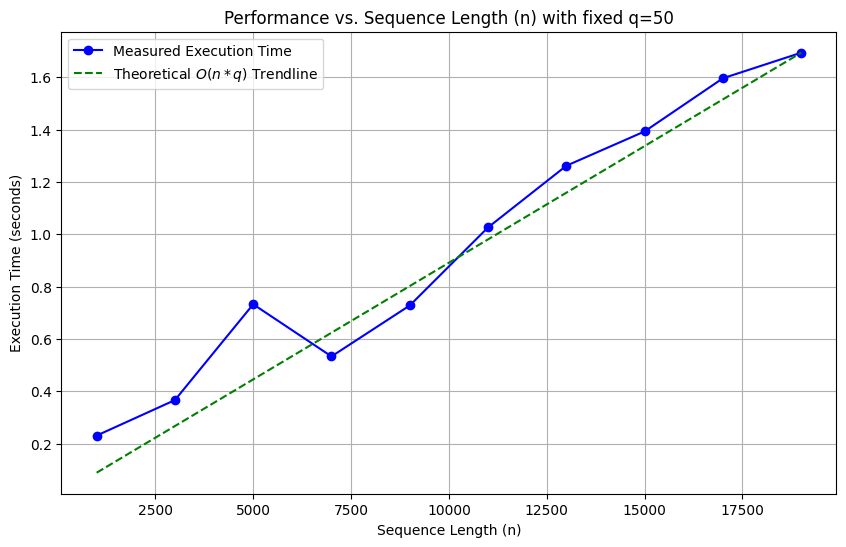


--- Experiment 2: Performance vs. Max Segment Length (q) ---


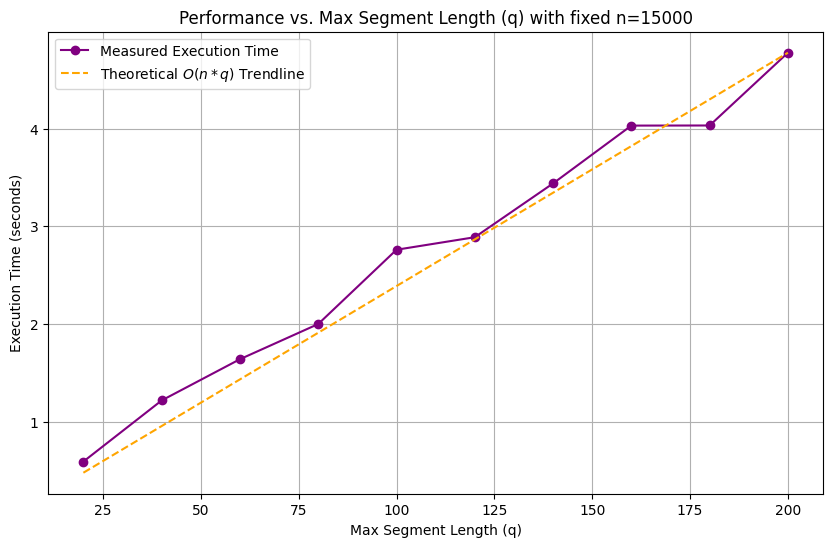

In [14]:
make_plots()

problem: 


In [ ]:
def segment_multi_channel(x: np.ndarray, p: float, q: int):
    """
    Similar to segment but with multiple channels.

    Args:
        x: Input signal (numpy 2d array, where rows are different channels)
        p: Penalty parameter
        q: Maximum segment length

    Returns:
        s: numpy Array of segments. Shaped (n, 2), each row in format [start, end]
        c: Total cost value of optimal segmentation
    """

    # TODO: implement
    return None

In [ ]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Process signal data from a text file.')
    parser.add_argument('--filepath', type=str, required=True, help='Path to the input text file')
    parser.add_argument('--penalty', type=float, required=True, help='Penalty parameter')
    parser.add_argument('--max_len', type=int, required=True, help='Maximum segment length')
    parser.add_argument('--is_multi_channel', type=bool, required=False, default=False, help='call segment_multi_channel')
    args = parser.parse_args()

    seq = read_signal_file(args.filepath)

    if args.is_multi_channel:
        pass # TODO: implement only if you completed the bonus part
    else:
        segments, total_cost = segment(seq, args.penalty, args.max_len)
        print_segments(segments, total_cost)